# Women Harassment Risk Predictor - Model Training

This notebook contains the complete machine learning pipeline for training a harassment risk prediction model.

## Overview
This notebook covers:
1. **Import Required Libraries** - Load all necessary ML and visualization libraries
2. **Load and Prepare Data** - Load processed dataset and split into train/test sets
3. **Train Multiple Models** - Train and compare different ML algorithms
4. **Evaluate Model Performance** - Assess model performance with various metrics
5. **Hyperparameter Tuning** - Optimize the best performing model
6. **Save Trained Model** - Save the final model for deployment
7. **Visualize Training History** - View model comparison and performance visualizations

---

## 1. Import Required Libraries

Import all necessary libraries for data processing, machine learning, and visualization.

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve
)

# Model persistence
import joblib

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load and Prepare Data

Load the processed dataset from CSV file and prepare it for modeling.

In [7]:
# Load the processed dataset
data_path = "../data/women_risk_processed.csv"

print("=" * 60)
print("LOADING PROCESSED DATASET")
print("=" * 60)

data = pd.read_csv(data_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {data.shape}")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")

# Display first few rows
print("\nFirst 5 rows:")
data.head()

LOADING PROCESSED DATASET

Dataset loaded successfully!
Shape: (115, 14)
Number of Rows: 115
Number of Columns: 14

First 5 rows:


,Timestamp,1. What is your age group?,2. What is your occupation?,3. At what time of day did the incident occur?,4. Where did the incident occur?,5. How crowded was the location at the time of the incident?,6. What was the lighting condition in the area?,7. Was any form of security present at the location?,8. Were you familiar with the area where the incident occurred?,9. What type of harassment did you experience?,10. How often have you experienced harassment in similar situations?,11. How safe did you feel during the incident?,"12. Overall, how would you rate the risk level of harassment in that situation?",risk
0,-1.717054,-1.101957,0.768289,0.050825,0.447315,1.626236,-0.035267,0.638877,0.438805,-0.086657,0.886103,-0.205660,2.179449,1
1,-1.686931,-1.101957,0.768289,0.050825,-0.369212,-1.378055,0.775880,0.638877,1.130072,-0.086657,-1.843410,2.328366,1.300022,1
2,-1.656807,-1.101957,0.768289,1.512033,-1.185740,0.875163,1.587028,0.638877,-0.943731,-0.917117,0.886103,1.483691,1.300022,1
3,-1.626683,-1.101957,0.768289,1.512033,-0.369212,-1.378055,0.775880,0.638877,0.438805,-0.086657,-0.023735,1.483691,-1.338258,0
4,-1.596559,-0.233977,0.038097,-0.679780,0.447315,0.124090,-0.035267,1.557262,-0.252463,1.574264,0.886103,1.483691,-1.338258,0


In [9]:
# Split data into features (X) and target (y)
target_col = 'risk'
X = data.drop(target_col, axis=1)
y = data[target_col]

# Split into training and testing sets
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

print("\n" + "=" * 60)
print("DATA SPLIT INTO TRAIN AND TEST SETS")
print("=" * 60)
print(f"\nTraining set size: {X_train.shape[0]} ({(1-test_size)*100:.0f}%)")
print(f"Testing set size: {X_test.shape[0]} ({test_size*100:.0f}%)")
print(f"\nFeatures: {X_train.shape[1]}")

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTesting set target distribution:")
print(y_test.value_counts())


DATA SPLIT INTO TRAIN AND TEST SETS

Training set size: 92 (80%)
Testing set size: 23 (20%)

Features: 13

Training set target distribution:
risk
1    49
0    43
Name: count, dtype: int64

Testing set target distribution:
risk
1    12
0    11
Name: count, dtype: int64


## 3. Train Multiple Models

Train and compare multiple classification algorithms using 5-fold cross-validation.

In [10]:
# Define multiple classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

print("=" * 60)
print("TRAINING MULTIPLE MODELS")
print("=" * 60)
print("\nPerforming 5-fold cross-validation for each model...\n")
print(f"{'Model':<25} {'Mean Accuracy':<15} {'Std Dev':<10}")
print("-" * 50)

for name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'model': model,
        'mean_accuracy': scores.mean(),
        'std_dev': scores.std(),
        'scores': scores
    }
    print(f"{name:<25} {scores.mean():<15.4f} {scores.std():<10.4f}")

# Find best model
best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
print(f"\n{'='*50}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Mean Accuracy: {results[best_model_name]['mean_accuracy']:.4f}")
print(f"{'='*50}")

TRAINING MULTIPLE MODELS

Performing 5-fold cross-validation for each model...

Model                     Mean Accuracy   Std Dev   
--------------------------------------------------
Logistic Regression       0.9889          0.0222    
Decision Tree             1.0000          0.0000    
Random Forest             1.0000          0.0000    
Gradient Boosting         1.0000          0.0000    
SVM                       0.8357          0.0713    

🏆 BEST MODEL: Decision Tree
   Mean Accuracy: 1.0000


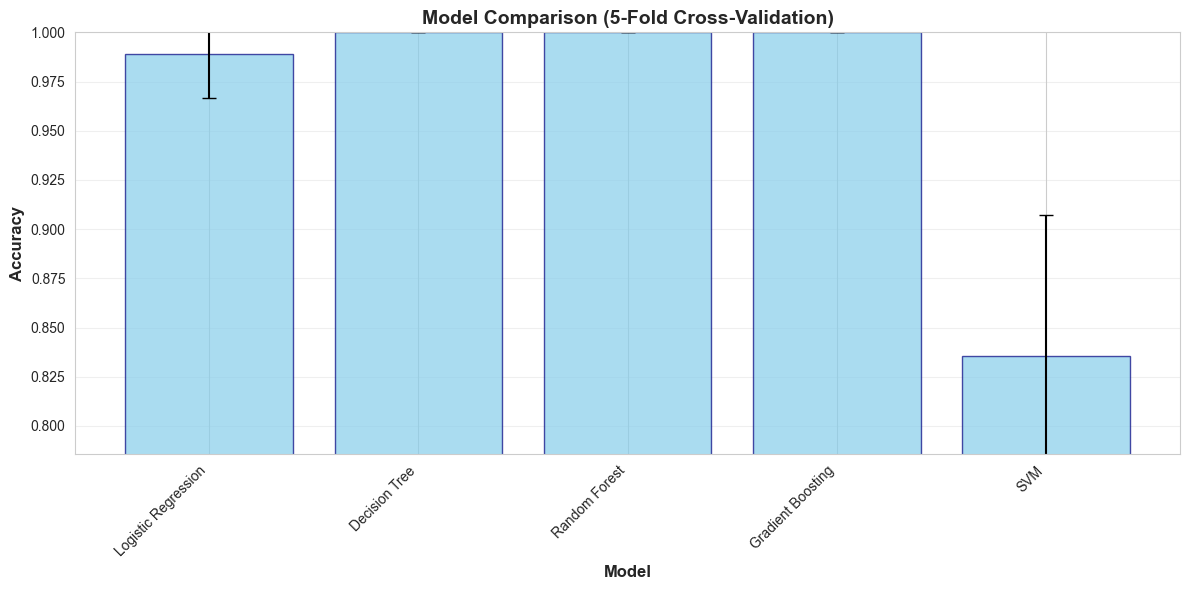

In [11]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
mean_accuracies = [results[name]['mean_accuracy'] for name in model_names]
std_devs = [results[name]['std_dev'] for name in model_names]

plt.bar(model_names, mean_accuracies, yerr=std_devs, capsize=5, 
        color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Comparison (5-Fold Cross-Validation)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([min(mean_accuracies) - 0.05, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Evaluate Model Performance

Train the best model on full training set and evaluate its performance on the test set using various metrics.

In [12]:
# Train the best model on full training set
best_model = results[best_model_name]['model']
best_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print(f"MODEL PERFORMANCE - {best_model_name}")
print("=" * 60)
print(f"\n{'Metric':<20} {'Score':<10}")
print("-" * 30)
print(f"{'Accuracy:':<20} {accuracy:<10.4f}")
print(f"{'Precision:':<20} {precision:<10.4f}")
print(f"{'Recall:':<20} {recall:<10.4f}")
print(f"{'F1-Score:':<20} {f1:<10.4f}")
print(f"{'ROC-AUC:':<20} {roc_auc:<10.4f}")
print("\n" + "=" * 60)

MODEL PERFORMANCE - Decision Tree

Metric               Score     
------------------------------
Accuracy:            1.0000    
Precision:           1.0000    
Recall:              1.0000    
F1-Score:            1.0000    
ROC-AUC:             1.0000    



In [13]:
# Display classification report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Low Risk (0)', 'High Risk (1)']))
print("=" * 60)

CLASSIFICATION REPORT
               precision    recall  f1-score   support

 Low Risk (0)       1.00      1.00      1.00        11
High Risk (1)       1.00      1.00      1.00        12

     accuracy                           1.00        23
    macro avg       1.00      1.00      1.00        23
 weighted avg       1.00      1.00      1.00        23



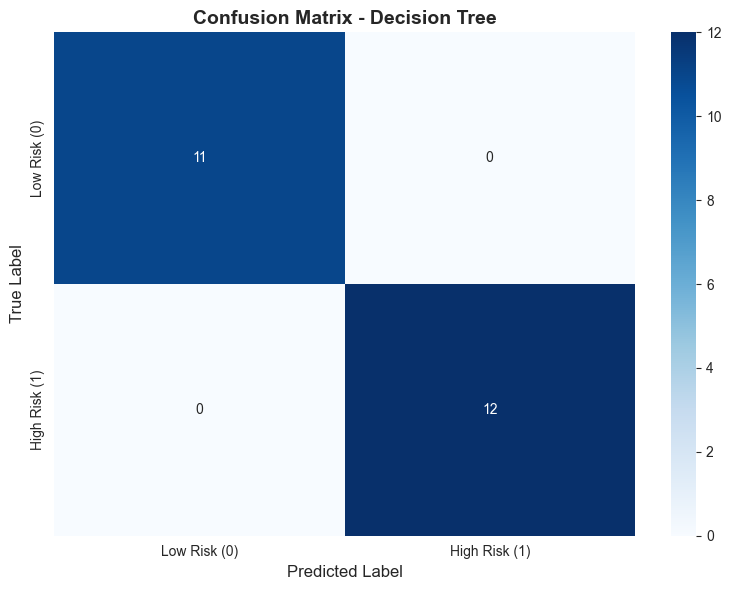


Confusion Matrix Values:
[[11  0]
 [ 0 12]]


In [14]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Low Risk (0)', 'High Risk (1)'],
            yticklabels=['Low Risk (0)', 'High Risk (1)'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Values:")
print(cm)

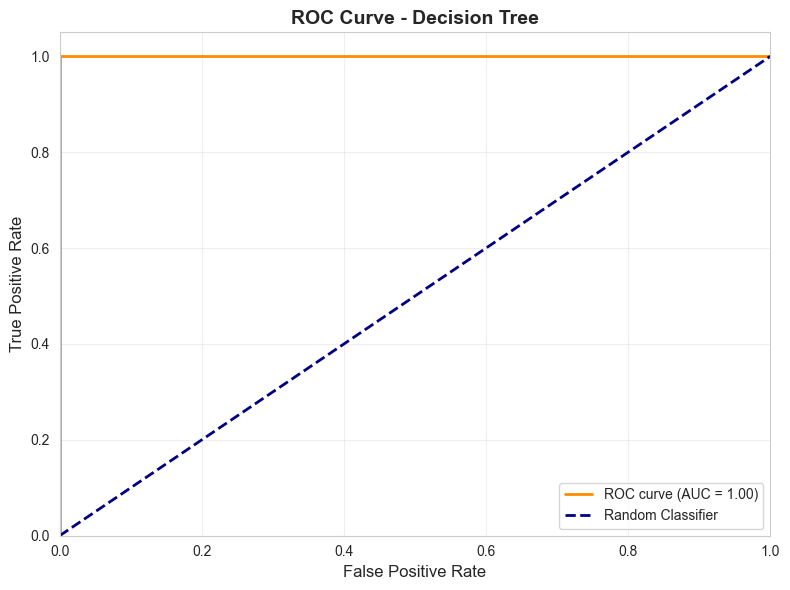

In [15]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

Optimize the best model's hyperparameters using GridSearchCV to improve performance.

In [16]:
# Define hyperparameter grids for different models
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ['l2'],
        "solver": ['lbfgs', 'liblinear']
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ['gini', 'entropy']
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    }
}

print("=" * 60)
print(f"HYPERPARAMETER TUNING FOR {best_model_name}")
print("=" * 60)

if best_model_name in param_grids:
    print(f"\nSearching best parameters...")
    print(f"Parameter grid: {param_grids[best_model_name]}")
    
    # Create fresh model instance
    models_dict = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42)
    }
    
    grid = GridSearchCV(
        models_dict[best_model_name], 
        param_grids[best_model_name], 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    print("\n" + "-" * 60)
    print("BEST PARAMETERS FOUND:")
    print("-" * 60)
    for param, value in grid.best_params_.items():
        print(f"{param}: {value}")
    
    print(f"\nBest Cross-Validation Accuracy: {grid.best_score_:.4f}")
    
    # Use the best estimator
    tuned_model = grid.best_estimator_
    best_params = grid.best_params_
else:
    print(f"\nNo hyperparameter grid defined for {best_model_name}")
    tuned_model = best_model
    best_params = {}

HYPERPARAMETER TUNING FOR Decision Tree

Searching best parameters...
Parameter grid: {'max_depth': [None, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 90 candidates, totalling 450 fits

------------------------------------------------------------
BEST PARAMETERS FOUND:
------------------------------------------------------------
criterion: gini
max_depth: None
min_samples_leaf: 1
min_samples_split: 2

Best Cross-Validation Accuracy: 1.0000


In [17]:
# Evaluate the tuned model on test set
y_pred_tuned = tuned_model.predict(X_test)
y_pred_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average='binary')
recall_tuned = recall_score(y_test, y_pred_tuned, average='binary')
f1_tuned = f1_score(y_test, y_pred_tuned, average='binary')
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE (AFTER HYPERPARAMETER TUNING)")
print("=" * 60)
print(f"\n{'Metric':<20} {'Before Tuning':<15} {'After Tuning':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Accuracy:':<20} {accuracy:<15.4f} {accuracy_tuned:<15.4f} {accuracy_tuned - accuracy:<15.4f}")
print(f"{'Precision:':<20} {precision:<15.4f} {precision_tuned:<15.4f} {precision_tuned - precision:<15.4f}")
print(f"{'Recall:':<20} {recall:<15.4f} {recall_tuned:<15.4f} {recall_tuned - recall:<15.4f}")
print(f"{'F1-Score:':<20} {f1:<15.4f} {f1_tuned:<15.4f} {f1_tuned - f1:<15.4f}")
print(f"{'ROC-AUC:':<20} {roc_auc:<15.4f} {roc_auc_tuned:<15.4f} {roc_auc_tuned - roc_auc:<15.4f}")
print("\n" + "=" * 60)


FINAL MODEL PERFORMANCE (AFTER HYPERPARAMETER TUNING)

Metric               Before Tuning   After Tuning    Improvement    
----------------------------------------------------------------------
Accuracy:            1.0000          1.0000          0.0000         
Precision:           1.0000          1.0000          0.0000         
Recall:              1.0000          1.0000          0.0000         
F1-Score:            1.0000          1.0000          0.0000         
ROC-AUC:             1.0000          1.0000          0.0000         



## 6. Save the Trained Model

Save the final optimized model, along with training information and metadata.

In [20]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained model
model_path = '../models/women_risk_model.pkl'
joblib.dump(tuned_model, model_path)

print("=" * 60)
print("MODEL SAVED SUCCESSFULLY")
print("=" * 60)
print(f"\nModel: {best_model_name}")
print(f"Saved to: {model_path}")
print(f"Test Accuracy: {accuracy_tuned:.4f}")
print("\n" + "=" * 60)

MODEL SAVED SUCCESSFULLY

Model: Decision Tree
Saved to: ../models/women_risk_model.pkl
Test Accuracy: 1.0000



In [22]:
# Save model information to text file
model_info_path = '../models/model_info.txt'

with open(model_info_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("WOMEN RISK PREDICTION MODEL INFORMATION\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("-" * 60 + "\n")
    f.write("Dataset Information:\n")
    f.write("-" * 60 + "\n")
    f.write(f"Total Samples: {len(data)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Testing Samples: {len(X_test)}\n")
    f.write(f"Number of Features: {X_train.shape[1]}\n\n")
    
    f.write("-" * 60 + "\n")
    f.write("Best Hyperparameters:\n")
    f.write("-" * 60 + "\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write("\n")
    
    f.write("-" * 60 + "\n")
    f.write("Performance Metrics (Test Set):\n")
    f.write("-" * 60 + "\n")
    f.write(f"Accuracy:  {accuracy_tuned:.4f}\n")
    f.write(f"Precision: {precision_tuned:.4f}\n")
    f.write(f"Recall:    {recall_tuned:.4f}\n")
    f.write(f"F1-Score:  {f1_tuned:.4f}\n")
    f.write(f"ROC-AUC:   {roc_auc_tuned:.4f}\n")

print(f"Model information saved to: {model_info_path}")

Model information saved to: ../models/model_info.txt


## 7. Visualize Training History

Compare model performance and visualize final results.

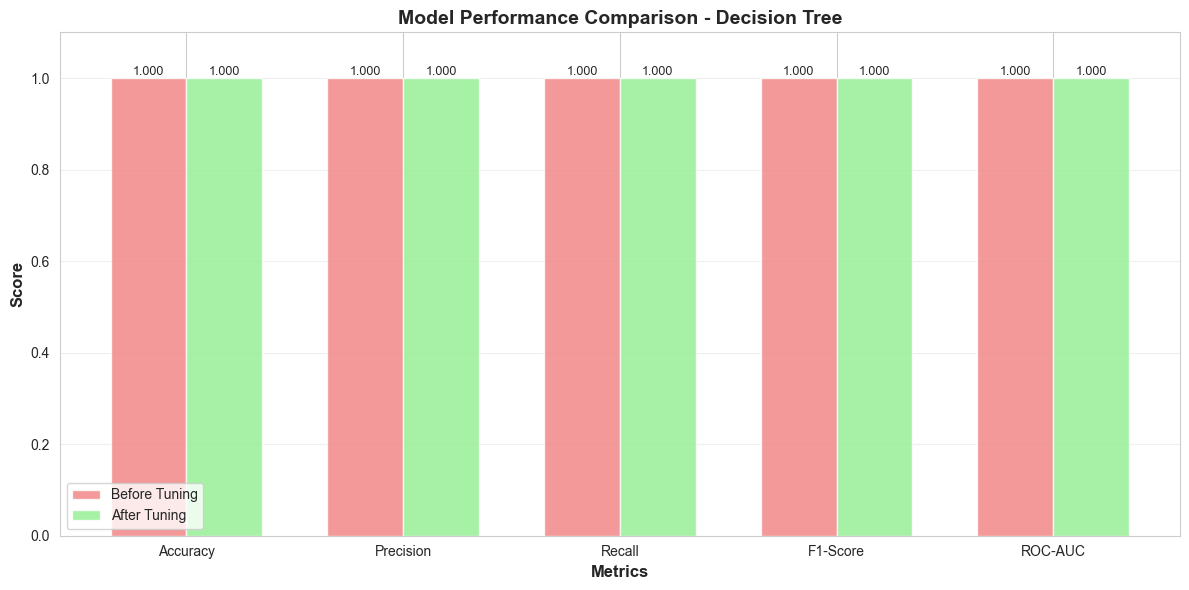

: 

In [ ]:
# Visualize performance comparison: Before vs After Tuning
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
before_tuning = [accuracy, precision, recall, f1, roc_auc]
after_tuning = [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned, roc_auc_tuned]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, before_tuning, width, label='Before Tuning', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x + width/2, after_tuning, width, label='After Tuning', color='lightgreen', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Model Performance Comparison - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## ✅ Training Complete!

The model has been successfully trained, optimized, and saved. Here's a summary:

### 📊 Model Information
- **Best Model:** Check the output above for the selected model
- **Model Location:** `../models/women_risk_model.pkl`
- **Model Info:** `../models/model_info.txt`

### 🎯 Key Steps Completed
1. ✅ Loaded and prepared processed dataset
2. ✅ Split data into training (80%) and testing (20%) sets
3. ✅ Trained and compared 5 different ML algorithms
4. ✅ Evaluated model performance with multiple metrics
5. ✅ Performed hyperparameter tuning using GridSearchCV
6. ✅ Saved optimized model for deployment
7. ✅ Generated performance visualizations

### 📈 Performance Metrics
Check the comparison visualization above to see improvements after hyperparameter tuning.

### 🚀 Next Steps
1. **Deploy the Model:** Use the saved model in your Flask application
2. **Test Predictions:** Run `test_api.py` to test the API endpoints
3. **Monitor Performance:** Track predictions and collect feedback
4. **Retrain:** Periodically retrain with new data to improve accuracy

---
**Note:** Make sure the Flask API (`app.py`) loads the correct model file path.